<a href="https://colab.research.google.com/github/Schumacher-group/post--growing-ca/blob/master/Growing_Neural_Cellular_Automata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Growing Neural Cellular Automata

This notebook contains code to reproduce experiments and figures for the ["Growing Neural Cellular Automata"](http://distill.pub/2020/growing-ca) article.

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [2]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

# import os # interactions with the operating system 
import io # file-related input and output operations
import PIL.Image, PIL.ImageDraw 
import base64
import zipfile
import json # compiled code is used to store and transport data
import requests # allows to send http request in python to store data
import numpy as np # support for multi-dimensional arrays and matrices
import matplotlib.pylab as pl # necessary for visualizations
import glob # pathnames

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm # shows progress bar 

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg' 
# program to process videos and files in command-line
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import cv2 # to save videos 

clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [3]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}
# 🐽

EXPERIMENT_TYPE = "Growing" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

# manual selection of growing 
USE_PATTERN_POOL = [0][0]
# [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0][0]
# [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [4]:
#@title CA Model and Utilities

from tensorflow.keras.layers import Conv2D

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

# adapted function to read mouse stem cell image
def load_image_real(url, max_size): 
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))

  # resize the image 
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  
  img = np.float32(img)/255.0 
  # 255 as maximum value for white possible, normalization

  # define alpha vector (default 1)
  insert_alpha = [[1]] * max_size

  # add alpha entry 
  img_alpha = np.empty(shape = (len(img), max_size, 4), dtype='object')


  # insert alpha channel 
  for i in range(len(img)):
    subsec = img[i:i+1, ...][0, ...] 
    subsec = np.append(subsec, insert_alpha, axis = 1)
    img_alpha[i:i+1, ...] = subsec


  # get (i, j) positions of all RGB pixels that are black (i.e. [0, 0, 0])
  black_pixels = np.where(
      (img_alpha[:, :, 0] < 0.3) & 
      (img_alpha[:, :, 1] < 0.3) & 
      (img_alpha[:, :, 2] < 0.3)
  )

  # set those pixels to white
  img_alpha[black_pixels] = [1., 1., 1., 0.]

  # encode as float number 
  img_alpha = np.float32(img_alpha)
  
  # premultiply RGB by Alpha
  img_alpha[..., :3] *= img_alpha[..., 3:]

  return(img_alpha)

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)


def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  # input is a tensor
  # clips values at min 0 and max 1
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x):
  alpha = x[:, :, :, 3:4]
  # performs max pooling on input 
  # window size 3
  # stride of the window when sliding 
  # SAME padding 
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(size, n=1):
  # initialize tensor of certain shape with 0
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__() # initialize 
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    # define neural network after convolution layer 
    # with ReLU activation and simple linear transformation for output
    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    # 3 filter 
    # 1. identity filter
    identify = np.outer(identify, identify)
    # Sobel filter for x-axis
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0 
    # Sobel filter for y-axis
    dy = dx.T

    # possible rotation 
    c, s = tf.cos(angle), tf.sin(angle)

    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)

    # construct perception vector through convolution layer 
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  # implement forward pass of layers in init() function 
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle)

    # residual update for new cell stage 
    dx = self.dmodel(y)*step_size

    # stochastic update of cells 
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    # output of neural network, masked by stochasticity 
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    # check for aliveness of cells pre and post update 
    # (only if alive at both times a non-zero state is valid)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)

# output model summary 
CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 3, 3, 128)            6272      
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 3, 3, 16)             2064      
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


# Training

In [6]:
#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

#@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


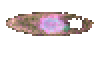

In [26]:
#@title Choose Target Image { vertical-output: true}

# size of the target image 
desired_size = 48

# 1) mouse stem cell image as input 
  # a. after 48 hours
url_cell_intermediate ='https://raw.githubusercontent.com/Schumacher-group/post--growing-ca/master/data/S2_48h_Col_1_scaled(RGB)_212x129.tif?raw=true'

  # b. after 60 hours
url_cell_final = 'https://raw.githubusercontent.com/Schumacher-group/post--growing-ca/master/data/S2_60h_Col_1_scaled(RGB)_217x129.tif?raw=true'

intermediate_img = load_image_real(url_cell_intermediate, desired_size)
target_img = load_image_real(url_cell_final, desired_size)


# 2) emoji as input  
# target_img = load_emoji(TARGET_EMOJI)

imshow(zoom(to_rgb(target_img), 2), fmt='png')



In [ ]:
#@title Initialize Training { vertical-output: true}

p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]

# INTITIAL STATE 

# define one single black pizel seed state
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

# define loss function for backpropagation
def loss_f(x):
  # only difference in first 4 columns relevant 
  return tf.reduce_mean(tf.square(to_rgba(x) - pad_target), [-2, -3, -1])

# neural cellular automata 
ca = CAModel()

# empty array to save log loss value in each training iteration 
loss_log = []

# schedule for the learning rate
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])


# define ADAM algorithm to optimize 
trainer = tf.keras.optimizers.Adam(lr_sched)

# initial loss for seed (maximum loss)
loss0 = loss_f(seed).numpy()

# initial set up of the batch pool
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

!mkdir -p train_log && rm -f train_log/*

batch (before/after):


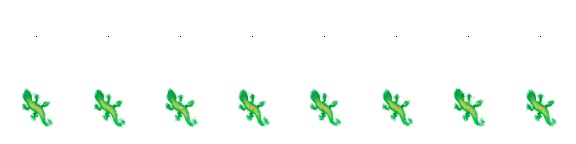

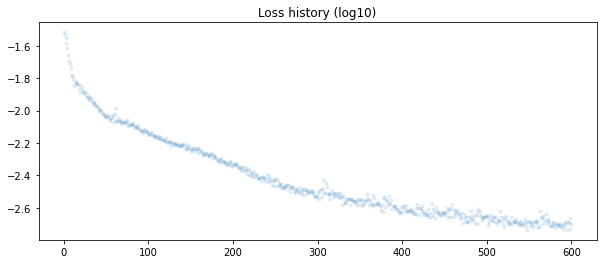

 step: 606, log10(loss): -2.687

KeyboardInterrupt: ignored

In [ ]:
#@title Training Loop {vertical-output: true}

@tf.function
def train_step(x):
  # random choice of steps after which the final state should be obtained 
  # acc. to pixel size of the output image (here 48)
  iter_n = tf.random.uniform([], 64, 96, tf.int32)

  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      # send x once through neural network and use output as input for next iteration
      x = ca(x)
      # reduces loss (difference between RGB value of current output and target) across all three dimensions 
    loss = tf.reduce_mean(loss_f(x))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

def train_step_two_targets(x):
  # random choice of steps after which the final state should be obtained 
  # acc. to pixel size of the output image (here 48)
  iter_n = 60

  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      # send x once through neural network and use output as input for next iteration
      x = ca(x)
      # reduces loss (difference between RGB value of current output and target) across all three dimensions 
    loss = tf.reduce_mean(loss_f(x))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(8000+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    loss_rank = loss_f(x0).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    x0[:1] = seed # always include seed state in batch 
    if DAMAGE_N:
      damage = 1.0-make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
      x0[-DAMAGE_N:] *= damage
  else:
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss = train_step(x0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())
  
  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    visualize_batch(x0, x, step_i)
    plot_loss(loss_log)
    export_model(ca, 'train_log/%04d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

# Figures

In [ ]:
#@title Training Progress (Checkpoints)

models = []
for i in [100, 500, 1000, 4000]:
  ca = CAModel()
  ca.load_weights('train_log/%04d'%i)
  models.append(ca)

out_fn = 'train_steps_damage_%d.mp4'%DAMAGE_N
x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
mvp.ipython_display(out_fn)



In [ ]:
#@title Training Progress (Batches)
frames = sorted(glob.glob('train_log/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('batches.mp4')
mvp.ipython_display('batches.mp4')

In [ ]:
#@title Compare performance

print(min(loss_log))

# lizzard: 4.293312e-05 
# pig nose: 0.0001504272
# stem cell 
  # 48h: 6.941299e-05
  # 60h: 6.555613e-05

# compare loss at the end 

In [44]:
#@title Read TIFF image

# load individual channels  
url_cyan = 'https://raw.githubusercontent.com/Schumacher-group/post--growing-ca/master/data/cyan_channel_2.tiff?raw=true'
# 'https://github.com/Schumacher-group/post--growing-ca/blob/master/data/cyan_channel.tif?raw=true'
url_green = 'https://github.com/Schumacher-group/post--growing-ca/blob/master/data/green_channel.tif?raw=true'
url_magenta = 'https://github.com/Schumacher-group/post--growing-ca/blob/master/data/magenta_channel.tif?raw=true'
url_yellow = 'https://github.com/Schumacher-group/post--growing-ca/blob/master/data/yellow_channel.tif?raw=true'

url = 'https://raw.githubusercontent.com/Schumacher-group/post--growing-ca/master/data/S2_60h_Col_1_scaled.tif?raw=true'
url_manual = '/Users/stephaniearmbruster/Desktop/Edinburgh/data/S2_60h_Col_1_scaled.tif'



r_cyan = requests.get(url_cyan)
r_green = requests.get(url_green)
r_magenta = requests.get(url_magenta)
r_yellow = requests.get(url_yellow)


r = requests.get(url)
img = PIL.Image.open(io.BytesIO(r.content))

img_manual = PIL.Image.open(url_manual)
img_manual.show


img_cyan = PIL.Image.open(io.BytesIO(r_cyan.content))

img_green = PIL.Image.open(io.BytesIO(r_green.content))

img_magenta = PIL.Image.open(io.BytesIO(r_magenta.content))

img_yellow = PIL.Image.open(io.BytesIO(r_yellow.content))

max_size = 300
  # resize the image 
#img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
#img_lamina.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)

img_yellow = np.float32(img_yellow)
img_green = np.float32(img_green)
img_cyan = np.float32(img_cyan)

img = np.float32(img)
print(img)



  # 255 as maximum value for white possible, normalization


  # define alpha vector (default 1)
insert_alpha = [[1]] * max_size

  # add alpha entry 
img_alpha = np.empty(shape = (len(img), max_size, 4), dtype='object')


  # insert alpha channel 
#for i in range(len(img)):
 # subsec = img[i:i+1, ...][0, ...] 
  #subsec = np.append(subsec, insert_alpha, axis = 1)
  #img_alpha[i:i+1, ...] = subsec


  # get (i, j) positions of all RGB pixels that are black (i.e. [0, 0, 0])
#black_pixels = np.where(
 #     (img_alpha[:, :, 0] < 0.3) & 
  #    (img_alpha[:, :, 1] < 0.3) & 
   #   (img_alpha[:, :, 2] < 0.3)
  #)

  # set those pixels to white
#img_alpha[black_pixels] = [1., 1., 1., 0.]

  # encode as float number 
#img_alpha = np.float32(img_alpha)
  
  # premultiply RGB by Alpha
#img_alpha[..., :3] *= img_alpha[..., 3:]

# return(img_alpha)

FileNotFoundError: ignored